# Past work

#Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv

# Function to remove all quotation marks from text
def remove_quotes(df):
    df['text'] = df['text'].apply(lambda x: x.replace('"', ''))
    return df

def preprocess_and_split_data(input_file_path, output_dir):    
    # Load the data
    data = pd.read_csv(input_file_path)
    
    # Remove all quotation marks from the text column
    data = remove_quotes(data)
    
    # Check class distribution to determine if stratification is possible
    class_counts = data['verbose label'].value_counts()

    # Apply stratification only if all classes have more than one instance
    stratify_col = data['verbose label'] if all(class_counts >= 2) else None

    # Split data into 80% train and 20% test
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=stratify_col)

    # Check if stratification is possible for the test split
    test_class_counts = test_data['verbose label'].value_counts()
    stratify_test_col = test_data['verbose label'] if all(test_class_counts >= 2) else None

    # Further split the test data into 10% local test and 10% remote test
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=stratify_test_col)

    # Extract columns for training, local testing, and remote testing
    train_data_for_clustering = train_data[['text']]
    local_test_data_for_eval = local_test_data[['text', 'verbose label']]
    remote_test_data_for_eval = remote_test_data[['text', 'verbose label']]
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the datasets to CSV without quoting
    train_data_file = os.path.join(output_dir, "swe_qaqc_preproc_train.csv")
    local_test_data_file = os.path.join(output_dir, "swe_qaqc_local_test.csv")
    remote_test_data_file = os.path.join(output_dir, "swe_qaqc_remote_test.csv")

    # Save data without any quoting
    train_data_for_clustering.to_csv(train_data_file, index=False, header=True, quoting=csv.QUOTE_NONE, escapechar='\\')
    local_test_data_for_eval.to_csv(local_test_data_file, index=False, header=True, quoting=csv.QUOTE_NONE, escapechar='\\')
    remote_test_data_for_eval.to_csv(remote_test_data_file, index=False, header=True, quoting=csv.QUOTE_NONE, escapechar='\\')

    print(f"Data preprocessing complete. Files saved in: {output_dir}")

# Example usage
input_file_path = "data/QAQC/swe_qaqc_train.csv"
output_dir = "train_data"
preprocess_and_split_data(input_file_path, output_dir)

#Transformation

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('data/QAQC/50data.csv')

# Optional: Clean the text (e.g., lowercase, remove punctuation)
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

# Load pre-trained model tokenizer and model (BERT in this case)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # We don't need gradients for this step
        outputs = model(**inputs)
    # Return the embedding of the [CLS] token (first token, representing the whole sequence)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Apply the function to the 'text' column
df['embeddings'] = df['text'].apply(get_bert_embedding)

# Step 1: Now, we extract the embeddings for clustering
embeddings_matrix = np.array(df['embeddings'].to_list())

# Optional: Process structured data if it exists
# For instance, scaling numerical features
if 'numerical_column' in df.columns:
    scaler = StandardScaler()
    scaled_numerical_data = scaler.fit_transform(df[['numerical_column']])

    # Combine the numerical data with text embeddings
    combined_data = np.hstack((scaled_numerical_data, embeddings_matrix))
else:
    combined_data = embeddings_matrix

# Step 2: Apply KMeans Clustering
n_clusters = df['verbose label'].nunique()  # Number of unique verbose labels
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_data)

# Step 3: Apply PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(combined_data)

# Step 4: Visualize the clusters with different colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)

# Create a legend for the clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc='upper right')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Text Embeddings Clustering with PCA')
plt.show()

#Clustering

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.manifold import TSNE

# Step 1: Load the data from the CSV file
df = pd.read_csv('data/QAQC/swe_qaqc_train.csv')

# Step 2: Preprocess the free-text column ('text') using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(df['text'])

# Step 3: Preprocess the structured data (One-Hot Encode 'verbose label', 'coarse label', and 'fine label')
df_encoded = pd.get_dummies(df, columns=['verbose label', 'coarse label', 'fine label'], drop_first=True)

# Step 4: Select the features for clustering (excluding 'text' since it's handled by TF-IDF)
features = df_encoded.drop(['text'], axis=1)

# Step 5: Normalize the structured data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 6: Combine the structured and text data (TF-IDF vectors)
combined_features = hstack([scaled_features, tfidf_matrix]).toarray()

# Step 7: Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(combined_features)

# Step 8: Add the cluster labels to the original dataset
df['Cluster'] = kmeans.labels_

# Step 9: Use t-SNE for visualization of clusters
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(combined_features)

# Plot the clusters in a 2D space
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('KMeans Clustering with Free-Text Circumstances (t-SNE)')
plt.colorbar(label='Cluster')
plt.show()

# IsBit Research and Testing Notebook

## Initial Plan

The initial plan is to split the data set of 5451 question text data into three separate subsets.
The formatting of each data set is described below. The first set contains 80% of the parent data and is reserved for local training of different
clustering models. The remaining 20% are further divided into two unseen test sets of 10% each, one for remote testing exported to the application and another for local evaluation of models(hence containing the coarse-label).

`ML/data/QAQC_v1/swe_local_train.csv`: 

 This is the data source that is preprocessed and split into three subsets.

`ML/data/QAQC_v1/splits/local_train.csv `:

This is the first subset, where data rows are formatted as `Hur utvecklades träldomen i Ryssland?`. These are the questions used for training the local clustering models.

`ML/data/QAQC_v1/splits/local_test.csv`: 

This is the second subset formatted as `Hur utvecklades träldomen i Ryssland?, DESC`. These are questions with additional coarse labels used for local evaluation of the different clustering models.

`ML/data/QAQC_v1/splits/remote_test.csv` :

This is the third subset with the same formatting as the second one. These questions are meant to be used for user-tests exported to the application.

---

## QAQC Preprocessing

The following section will preprocess and split the source data into the three mentioned data slices, keep in mind that all data file names are in the .gitignore to avoid pushing data files to origin, download the source data set to the following path `ML/data/QAQC_v1` and run the preprocessing section to slice the data for training and testing. The souce data can be found at `https://spraakbanken.gu.se/en/resources/sveat` 

If further preprocessing is needed I suggest saving it under `ML/data/QAQC_v2/` and inserting the created file names into .gitignore.

The cells below will filter the source data and create new formatted csv files with the following changes in format compared to the source data,

- Removing commas inside the text field replacing then with pipe signs | .
- Removing outer quotations marks of the textfield.
- Insert escape chars where needed, mostly text fields containing quotes. 

Examples of both raw and processed data files with some normal and edge cases in the data rows can be found under `ML/data_exampels`

In [ ]:

# run
# pip install -r ML/requirements.txt

# or run these pip intall 
# > pip install scikit-learn
# > pip install -U sentence-transformers
# > pip install seaborn

# or uncomment lines below and run this cell.
#'%pip install scikit-learn'
#'%pip install sentence-transformers'
#'%pip install seaborn'

Downloads the source data.

In [2]:
import os
import requests

exists = os.path.isfile(os.path.join("./data/QAQC_v1", "swe_qaqc_train.csv"))
if exists:
    print("File exists")
else:
    dataset = "https://svn.spraakbanken.gu.se/sb-arkiv/pub/trec/swe_qaqc_train.csv"
    response = requests.get(dataset)
    open("./data/QAQC_v1/swe_qaqc_train.csv", "wb").write(response.content)
    print("File downloaded")

File downloaded


Removing of commas and quotations marks.

In [4]:
import pandas as pd
import csv
import re
import os

source_path = "data/QAQC_v1/swe_qaqc_train.csv"        # path to the source data, need to be downloaded ignored for git
output_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"   # set the same output path to not push data to git

# helper to remove outer quotation marks
def strip_outer_quotationmarks(q):
    if q.startswith('"') and q.endswith('"'):
        q = q[1:-1]  
    return q.strip()

# helper to remove commas in the question text, causes problems since the cols are set by commas in csv file
def replace_commas(line):
    pattern = r'"([^"]*?)"'
    def replace_commas(match):
        return '"' + match.group(1).replace(',', '|') + '"'
    return re.sub(pattern, replace_commas, line)

def process_csv(source_data_path, output_data_path, temp_file_path="temp_file.csv"):
    with open(source_data_path, 'r', encoding='utf-8') as infile:
        modified_lines = [replace_commas(line.strip()) for line in infile]

    with open(temp_file_path, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write('\n'.join(modified_lines))

    temp_data = pd.read_csv(temp_file_path, quoting=csv.QUOTE_NONE)  
    questions = temp_data["text"].tolist()
    no_comma_questions = [strip_outer_quotationmarks(q) for q in questions]

    coarse_labels = list(map(lambda x: x.split(":")[0], temp_data["verbose label"].tolist())) # only keep the coarse lable 
    zipped = list(zip(no_comma_questions, coarse_labels))

    with open(output_data_path, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["text", "coarse label"])
        writer.writerows(zipped)

    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)


    #print(f"Processed data saved to {output_data_path}") # trace print

# data formatted and ready for splitting 
_ = process_csv(source_path, output_path)

Data-split

Splits the formatted data into 80% local training data, 10% local test data and 10% remote user test data.

In [5]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['coarse label'])
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_data['coarse label'])
    
    local_train_data = train_data[['text']].copy()  # no need for the lable that wont be used as a lable
    
    local_test_data_for_eval = local_test_data[['text', 'coarse label']].copy()
    remote_test_data_for_eval = remote_test_data[['text', 'coarse label']].copy()
    
    local_train_file = os.path.join(split_path, "local_train.csv")
    local_test_file = os.path.join(split_path, "local_test.csv")
    remote_test_file = os.path.join(split_path, "remote_test.csv")
    
    local_train_data.to_csv(local_train_file, index=False, header=True)
    local_test_data_for_eval.to_csv(local_test_file, index=False, header=True)
    remote_test_data_for_eval.to_csv(remote_test_file, index=False, header=True)
    
    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v1/splits/"
data_split(source_path, split_path)


Data splits saved to: data/QAQC_v1/splits/


### Sentence Transformers (Gustav)

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danie\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-pack

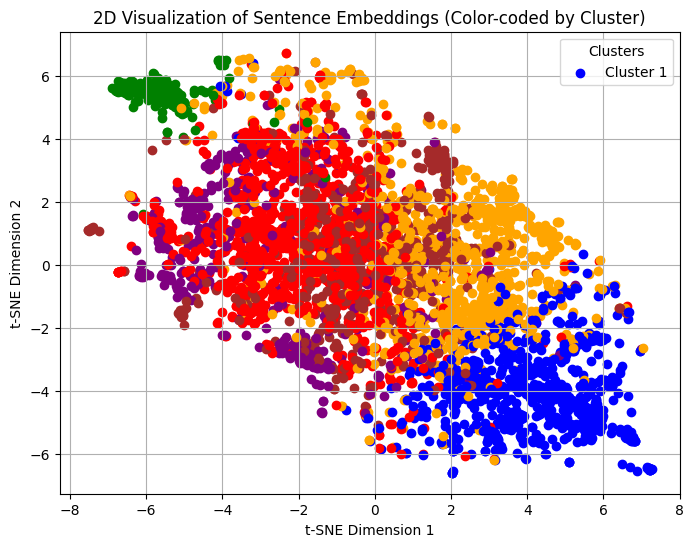

                                                text
0                                 Vad är stjärnfall?
1  Vad heter den lysande brittiska ekonomen bakom...
2  Vilken godbit efter middagen uppfanns 1916 på ...
3  Vilken fejd slutade med ett äktenskap i Kentuc...
4                Vad var målet för M3-tillväxt 1992?


In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Load sentences from the local training data
local_train_path = "data/QAQC_v1/splits/local_train.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 2: Use KMeans to cluster the embeddings into 6 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels for each embedding
cluster_labels = kmeans.labels_

# Step 3: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
}
colors = [color_map[label] for label in cluster_labels]

# Step 4: Apply t-SNE to reduce the embeddings to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 5: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

# Display the head of the DataFrame (local training data)
print(local_train_data.head())

### Tuples of sting and null

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 7/7 [00:00<00:00, 12.82it/s]
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


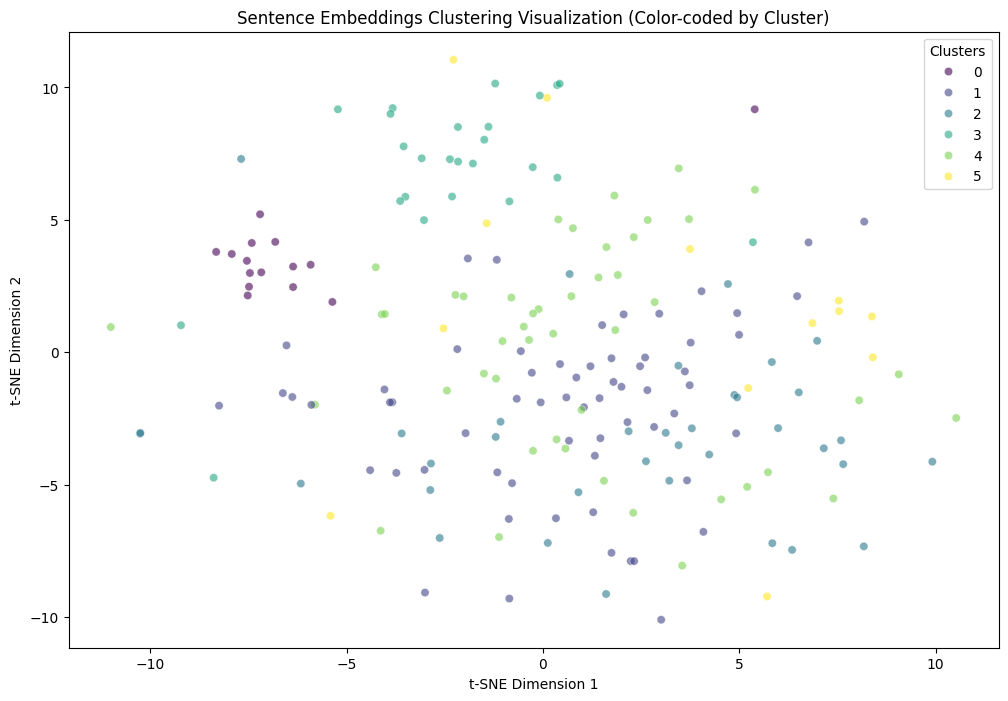

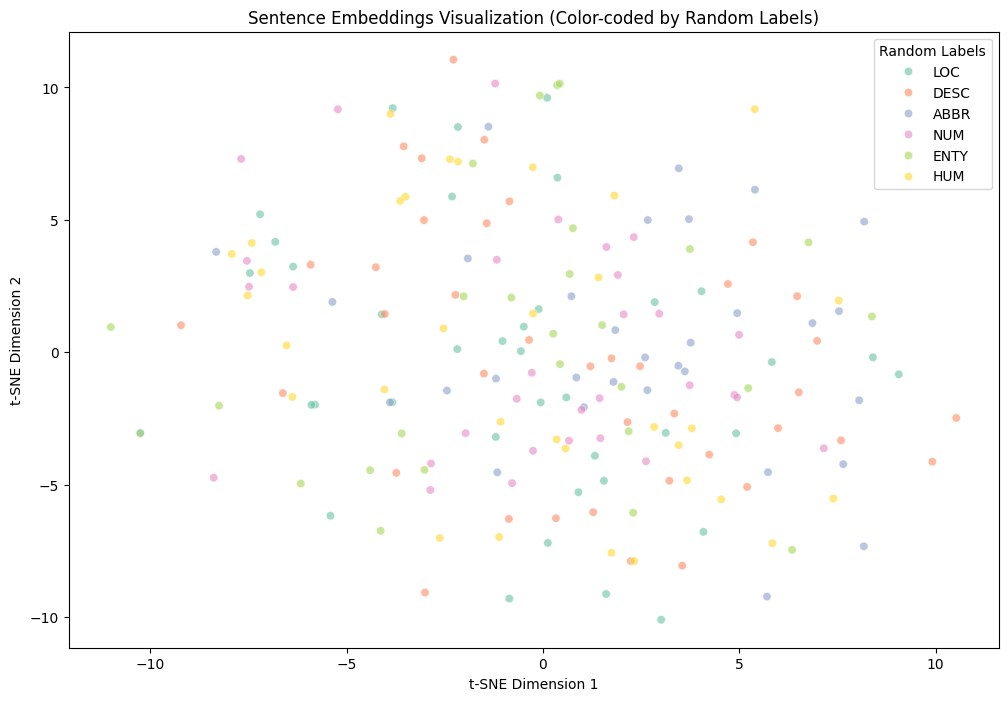

[('Vad är stjärnfall?', 'LOC'), ('Vad heter den lysande brittiska ekonomen bakom skapandet?', 'DESC'), ('Vilken godbit efter middagen uppfanns 1916 på George Jung-nudelfabriken i Los Angeles?', 'LOC'), ('Vilken fejd slutade med ett äktenskap i Kentucky den 21 mars 1891?', 'ABBR'), ('Vad var målet för M3-tillväxt 1992?', 'LOC')]


In [18]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt
import random

# Load sentences from the local training data
local_train_path = "data/QAQC_v1/splits/local_train50.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 2: Use KMeans to cluster the embeddings into 6 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels for each embedding
cluster_labels = kmeans.labels_

# Step 3: Apply t-SNE for 2D reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding_2d = tsne.fit_transform(embeddings)

# Create a DataFrame for the reduced embeddings and cluster labels
cluster_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
cluster_df['cluster'] = cluster_labels

# Step 4: Plot using Seaborn's scatterplot for the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6)
plt.title("Sentence Embeddings Clustering Visualization (Color-coded by Cluster)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Clusters")
plt.show()

# Format input data to tuples
formatted_data = [(row['text'], None) for index, row in local_train_data.iterrows()]

# Function to assign random labels to tuples with None values
def assign_random_labels(data):
    labels = ["DESC", "ENTY", "NUM", "HUM", "LOC", "ABBR"]
    labeled_data = [(sentence, random.choice(labels) if label is None else label) for sentence, label in data]
    return labeled_data

# Apply the function to formatted data to get random labels in place of None
random_labeled_data = assign_random_labels(formatted_data)

# Create a DataFrame for the reduced embeddings and random labels
_, random_labels = zip(*random_labeled_data)
label_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
label_df['random_label'] = random_labels

# Step 5: Plot the random labels using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=label_df, x='x', y='y', hue='random_label', palette='Set2', alpha=0.6)
plt.title("Sentence Embeddings Visualization (Color-coded by Random Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Random Labels")
plt.show()

# Display the first few tuples to verify the random labeling
print(random_labeled_data[:5])  # Print the first 5 tuples with randomly assigned labels


---
# SentenceTransformers + tuples + pd.NA + visualisation

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 7/7 [00:00<00:00, 10.84it/s]
C:\Users\danie\AppData\Local\Temp\ipykernel_19968\1965990533.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=cluster_df, x='x', y='y', palette='viridi

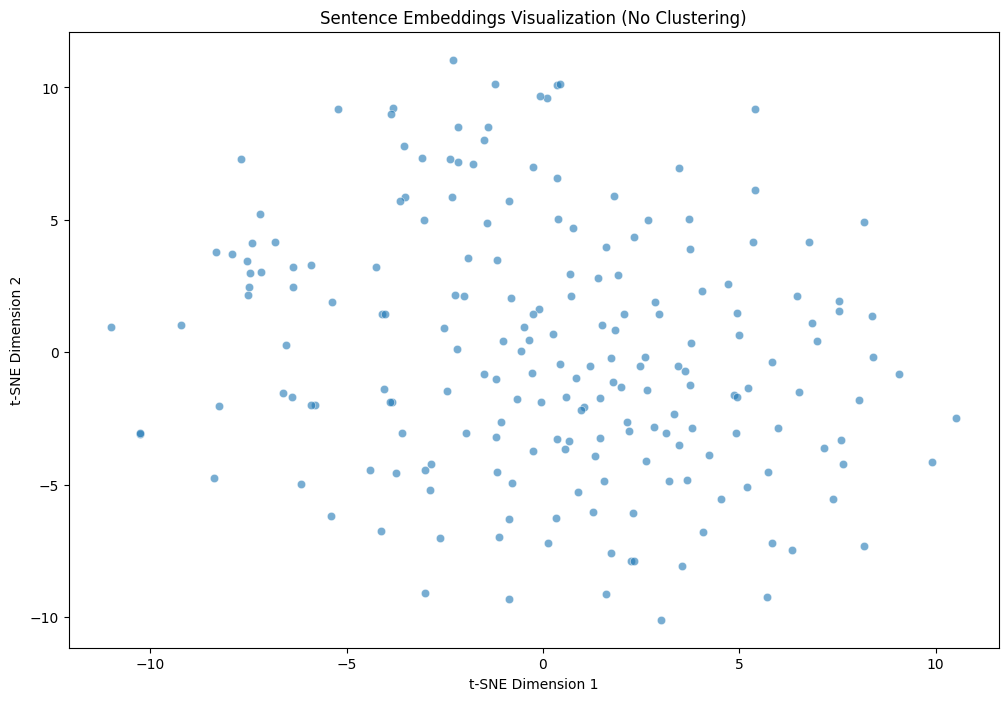

Number of entries with `pd.NA` as label before assignment: 199
Number of entries with `pd.NA` as label after assignment: 0


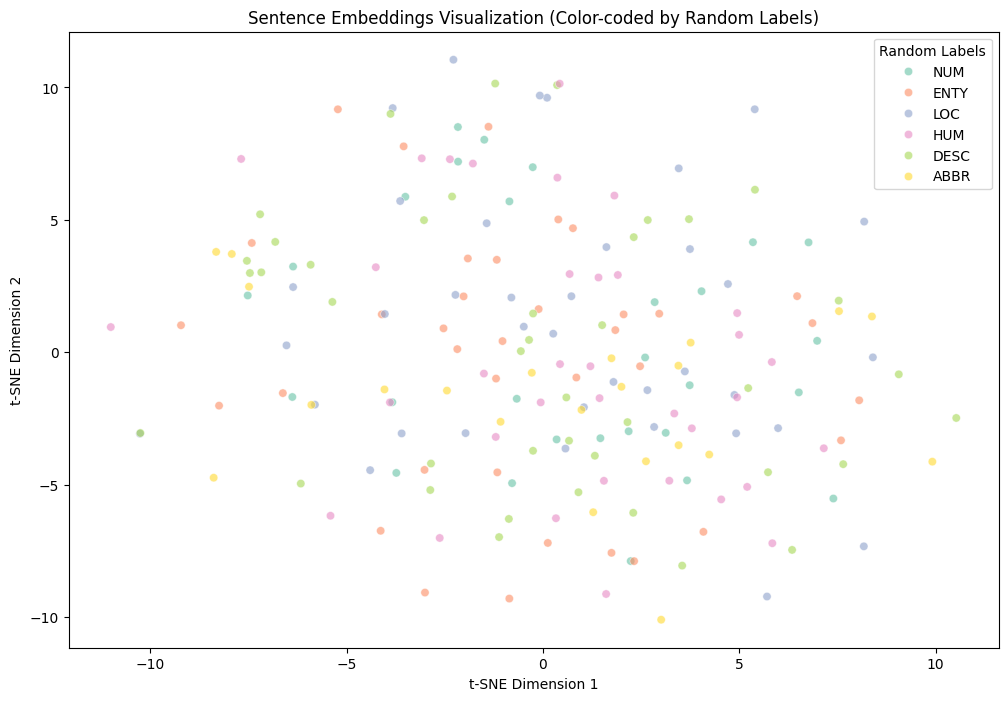

[('Vad är stjärnfall?', 'NUM'), ('Vad heter den lysande brittiska ekonomen bakom skapandet?', 'ENTY'), ('Vilken godbit efter middagen uppfanns 1916 på George Jung-nudelfabriken i Los Angeles?', 'ENTY'), ('Vilken fejd slutade med ett äktenskap i Kentucky den 21 mars 1891?', 'LOC'), ('Vad var målet för M3-tillväxt 1992?', 'HUM')]


In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt
import random

# Load sentences from the local training data
local_train_path = "data/QAQC_v1/splits/local_train50.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 2: Apply t-SNE for 2D reduction (no clustering used)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding_2d = tsne.fit_transform(embeddings)

# Step 3: Create a DataFrame for the reduced embeddings
cluster_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])

# Step 4: Plot using Seaborn's scatterplot for the t-SNE embeddings without clustering
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_df, x='x', y='y', palette='viridis', alpha=0.6)
plt.title("Sentence Embeddings Visualization (No Clustering)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 5: Format input data to tuples, using `pd.NA` for missing labels
formatted_data = [(row['text'], pd.NA) for index, row in local_train_data.iterrows()]

# Test 1: Check if `pd.NA` is used correctly
na_count = sum(1 for sentence, label in formatted_data if label is pd.NA)
print(f"Number of entries with `pd.NA` as label before assignment: {na_count}")

# Step 6: Function to assign random labels to tuples with `pd.NA` values
def assign_random_labels(data):
    labels = ["DESC", "ENTY", "NUM", "HUM", "LOC", "ABBR"]
    labeled_data = [(sentence, random.choice(labels) if label is pd.NA else label) for sentence, label in data]
    return labeled_data

# Apply the function to formatted data to replace `pd.NA` with random labels
random_labeled_data = assign_random_labels(formatted_data)

# Test 2: Verify no `pd.NA` labels remain after assignment
na_count_after = sum(1 for sentence, label in random_labeled_data if label is pd.NA)
print(f"Number of entries with `pd.NA` as label after assignment: {na_count_after}")

# Extract the random labels for plotting
_, random_labels = zip(*random_labeled_data)

# Step 7: Create a DataFrame for the reduced embeddings and random labels
label_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
label_df['random_label'] = random_labels

# Step 8: Plot the random labels using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=label_df, x='x', y='y', hue='random_label', palette='Set2', alpha=0.6)
plt.title("Sentence Embeddings Visualization (Color-coded by Random Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Random Labels")
plt.show()

# Display the first few tuples to verify the random labeling
print(random_labeled_data[:5])  # Print the first 5 tuples with randomly assigned labels


---
# SentenceTransformers (J)

Testing pre trained model referenced on official page of SentenceTransformer

C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


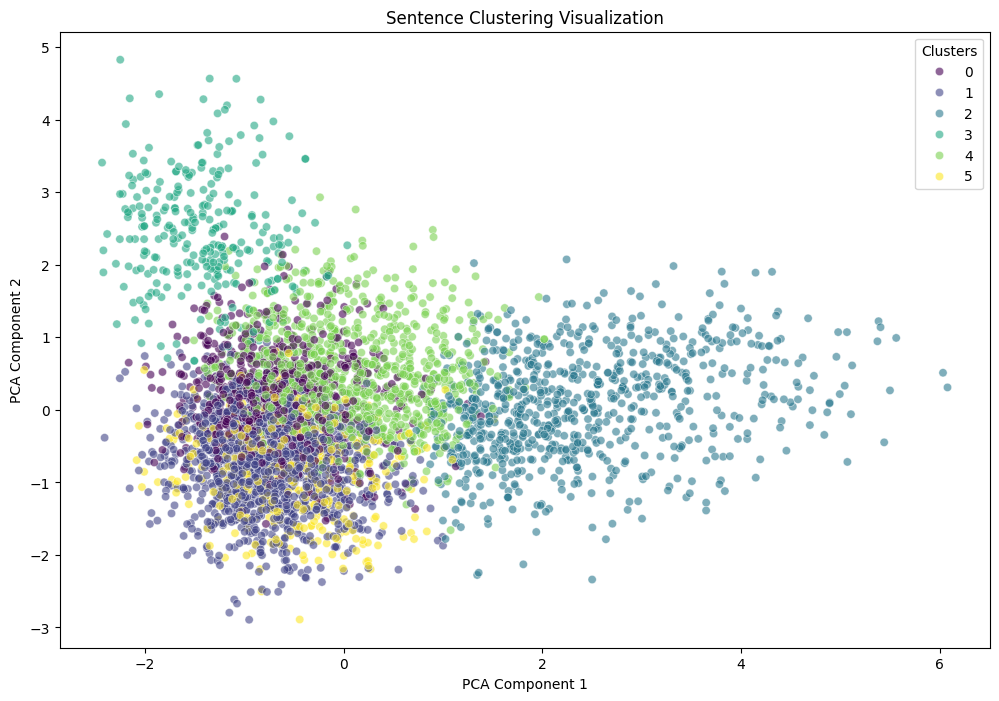

In [6]:


from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


train_data_path = 'data/QAQC_v1/splits/local_train.csv'
data = pd.read_csv(train_data_path)
sentences = data['text'].tolist() 

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, convert_to_tensor=True)
num_clusters = 6 # coarse lables: [LOC, HUM, DESC, ENTY, ABBR, NUM] 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings.cpu().numpy())
clusters = kmeans.labels_

# reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())

# frame
cluster_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
cluster_df['cluster'] = clusters

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6)
plt.title('Sentence Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Clusters')
plt.show()
